## Studets details

Student1
* Name:
* ID:
* Username:

Student2
* Name:
* ID:
* Username:

Student3
* Name:
* ID:
* Username:

### General tip

While debugging you might want to use:
```python
import importlib
importlib.reload(model)
```

to reload the model module without repeating unnecessary cells.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import relevant packages - you might need to pip install some 

In [ ]:
import torch
import sys
from os.path import dirname

sys.path.append('.')
sys.path.append('..')
sys.path.append('/content/drive/MyDrive/TAU/Advanced NLP/Ex1')

import data_loader
from traineval import train, evaluate
import model as model


import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"deviced used is {device}")

import importlib
importlib.reload(model)

%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
seed = 42

## Loading the Data

The following line of code invokes data_loader and will automatically download and extract the dataset if needed.
It instantiates the following variables;
* tokens_vocab - the sentence words vocabulary
* y_vocab - the labels (senses) vocabulary
* datasets - a dictionary with train,dev, and test WSDDataset instances.

Use the optional sentence_count kwarg to limit the number of sentences loaded.

In [ ]:
train_dataset, tokens_vocab, y_vocab = data_loader.load_train_dataset()
train_dataset

In [ ]:
dev_dataset = data_loader.load_dev_dataset(tokens_vocab, y_vocab)
dev_dataset

## Part 1: Query-Based Attention

Implement the relevant parts in model.py module. You might to check out this blog post about [gather method](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4)

Load the model.

In [ ]:
dropout = 0.25
D = 300
lr = 8e-5
batch_size=100
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(m, 
                                   optimizer, 
                                   train_dataset, 
                                   dev_dataset, 
                                   num_epochs=num_epochs, 
                                   batch_size=batch_size)

Train the model - you shoud see the loss decreasing and validation acc increasing from epoch to epoch.

In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.514, "The last validation accuracy should be at least 0.514. Please check your implementation before you continue"

Plot the loss and training/validation accuracy. You should be getting ~54% validation accuracy after 10 epochs.

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

Use the attention vizualization to get a feel of what the model is attending to.

The query token is highlighted in green, and the model's attention with a pink-blue gradient.
In addition, the loss is given a red gradient.

In [ ]:
from traineval import higlight_samples

higlight_samples(m, dev_dataset, sample_size=5)

## Part 2: Padding

Implement the padding mask in the attention function in model.py.

Load the model and retrain.

In [ ]:
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.527, "The last validation accuracy should be at least 0.527. Please check your implementation before you continue"

Plot the loss and training/validation accuracy.

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [ ]:
higlight_samples(m, dev_dataset, sample_size=5)

Examine additional examples, using the API and pandas as demonstrated below.

In [ ]:
import pandas as pd
import numpy as np
from traineval import evaluate_verbose, highlight

pd.set_option('max_columns', 100)

eval_df, attention_df = evaluate_verbose(m, dev_dataset, iter_lim=100)

Visualization of 5 incorrectly classified examples.

In [ ]:
idxs = np.where(eval_df['y_true'] != eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

Visualization of examples with the query word "left".

In [ ]:
idxs = np.where(eval_df['query_token'] == 'left')
highlight(eval_df, attention_df, idxs)

## Part 3: Self-Attention

The method below converts the query-based instances in WSDDataset to sentence-level instances in WSDSentencesDataset for self-attention.

Notice how the number of samples now equals number of sentences.

In [ ]:
sa_train_dataset = data_loader.WSDSentencesDataset.from_word_dataset(train_dataset)
sa_train_dataset

In [ ]:
sa_dev_dataset = data_loader.WSDSentencesDataset.from_word_dataset(dev_dataset)
sa_dev_dataset

Implement self-attention in the model.

Load the model and retrain.

In [ ]:
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=2
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

Plot the loss and training/validation accuracy.

In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
# assert val_acc[-1] >= 0.543, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

## Part 4: Positional embeddings  &  Part 5: Causal Attention


We do not provide "you code here" comments for this part as you should be familiar with the code by now

In [26]:
from warnings import warn


def train_eval_positional(num_epochs: int,
                          pos_exponent: int,
                          pos_cutoff_position: int,
                          pos_is_causal:bool,
                          pos_normalize_magnitude: bool,
                          DEBUG_dummy_train: bool = False) -> None:
    
    sa_train_dataset = data_loader.WSDSentencesDataset.from_word_dataset(train_dataset)
    sa_dev_dataset = data_loader.WSDSentencesDataset.from_word_dataset(dev_dataset)

    if DEBUG_dummy_train:
        sa_train_dataset = sa_dev_dataset
        warn("using dev set for training")
        print()
    
    lr=2e-4
    dropout = 0.2
    D=300
    batch_size=20
    set_seed(seed)

    m = model.WSDModel(
        tokens_vocab.size(), 
        y_vocab.size(), 
        D=D, 
        dropout_prob=dropout,
        use_padding=True,
        use_positional_encodings=True,
        pos_exponent=pos_exponent,
        pos_cutoff_position=pos_cutoff_position,
        pos_is_causal=pos_is_causal,
        pos_normalize_magnitude=pos_normalize_magnitude
    ).to(device)

    optimizer = torch.optim.Adam(m.parameters(), lr=lr)

    losses, train_acc, val_acc = train(
        m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)
    
    print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")

    fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

    axs[0].plot(losses, '-', label='Train Loss');
    axs[0].legend()
    axs[1].plot(train_acc, '-o', label='Train Acc');
    axs[1].plot(val_acc, '-o', label='Val Acc');
    axs[1].legend()

    plt.tight_layout()
    plt.show()




pos_is_causal: False  | pos_normalize_magnitude: False  | pos_exponent: 1


val: 0.000; epoch [0] loss: 4.721:  98%|██████████████████████████████████████████▎| 1463/1487 [08:55<00:08,  2.72it/s]


A
 tensor([[0.6611, 0.2175, 0.0792, 0.0310, 0.0113],
        [0.1849, 0.5304, 0.1917, 0.0683, 0.0248],
        [0.0682, 0.1854, 0.4882, 0.1919, 0.0663],
        [0.0259, 0.0671, 0.1818, 0.5343, 0.1909],
        [0.0115, 0.0306, 0.0795, 0.2325, 0.6459]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0., -1., -2., -3., -4.],
        [-1., -0., -1., -2., -3.],
        [-2., -1., -0., -1., -2.],
        [-3., -2., -1., -0., -1.],
        [-4., -3., -2., -1., -0.]], device='cuda:0')


val: 0.465; epoch [1] loss: 3.310:  85%|████████████████████████████████████▍      | 1261/1487 [07:43<01:23,  2.71it/s]


A
 tensor([[0.6347, 0.2323, 0.0846, 0.0302, 0.0113],
        [0.1751, 0.5403, 0.1805, 0.0652, 0.0244],
        [0.0644, 0.1803, 0.4782, 0.1744, 0.0654],
        [0.0235, 0.0639, 0.1711, 0.4588, 0.1784],
        [0.0082, 0.0221, 0.0591, 0.1717, 0.4806]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0., -1., -2., -3., -4.],
        [-1., -0., -1., -2., -3.],
        [-2., -1., -0., -1., -2.],
        [-3., -2., -1., -0., -1.],
        [-4., -3., -2., -1., -0.]], device='cuda:0')


val: 0.530; epoch [2] loss: 2.542:  44%|███████████████████▎                        | 652/1487 [04:00<05:07,  2.71it/s]


A
 tensor([[0.6307, 0.2353, 0.0868, 0.0308, 0.0121],
        [0.1927, 0.5058, 0.1946, 0.0713, 0.0261],
        [0.0645, 0.1748, 0.4923, 0.1791, 0.0656],
        [0.0239, 0.0678, 0.1825, 0.4835, 0.1748],
        [0.0099, 0.0251, 0.0716, 0.1927, 0.5092]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0., -1., -2., -3., -4.],
        [-1., -0., -1., -2., -3.],
        [-2., -1., -0., -1., -2.],
        [-3., -2., -1., -0., -1.],
        [-4., -3., -2., -1., -0.]], device='cuda:0')


evaluate:   2%|█▌                                                                    | 34/1487 [00:01<01:26, 16.86it/s]


A
 tensor([[0.6275, 0.2318, 0.0880, 0.0341, 0.0117],
        [0.2082, 0.4788, 0.1974, 0.0733, 0.0264],
        [0.0659, 0.1828, 0.4726, 0.1728, 0.0654],
        [0.0360, 0.0828, 0.2116, 0.3154, 0.2145],
        [0.0111, 0.0276, 0.0765, 0.2013, 0.3340]], device='cuda:0')

pos_rep
 tensor([[-0., -1., -2., -3., -4.],
        [-1., -0., -1., -2., -3.],
        [-2., -1., -0., -1., -2.],
        [-3., -2., -1., -0., -1.],
        [-4., -3., -2., -1., -0.]], device='cuda:0')


val: 0.557; epoch [3] loss: 1.933:  43%|██████████████████▊                         | 637/1487 [03:54<05:10,  2.74it/s]


A
 tensor([[0.6143, 0.2427, 0.0900, 0.0341, 0.0120],
        [0.2020, 0.4930, 0.1903, 0.0730, 0.0266],
        [0.0787, 0.1852, 0.4157, 0.2027, 0.0772],
        [0.0240, 0.0663, 0.1768, 0.4529, 0.1807],
        [0.0105, 0.0276, 0.0777, 0.2124, 0.3808]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0., -1., -2., -3., -4.],
        [-1., -0., -1., -2., -3.],
        [-2., -1., -0., -1., -2.],
        [-3., -2., -1., -0., -1.],
        [-4., -3., -2., -1., -0.]], device='cuda:0')


val: 0.569; epoch [4] loss: 1.569:  57%|████████████████████████▉                   | 841/1487 [05:15<03:57,  2.72it/s]


A
 tensor([[0.5005, 0.3056, 0.1282, 0.0410, 0.0155],
        [0.2073, 0.4192, 0.2476, 0.0798, 0.0281],
        [0.0719, 0.2200, 0.4020, 0.1972, 0.0692],
        [0.0243, 0.0665, 0.1889, 0.4278, 0.1838],
        [0.0089, 0.0255, 0.0755, 0.2103, 0.3698]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0., -1., -2., -3., -4.],
        [-1., -0., -1., -2., -3.],
        [-2., -1., -0., -1., -2.],
        [-3., -2., -1., -0., -1.],
        [-4., -3., -2., -1., -0.]], device='cuda:0')


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:05<00:00, 34.22it/s]


Validation accuracy: 0.580, Training accuracy:0.715


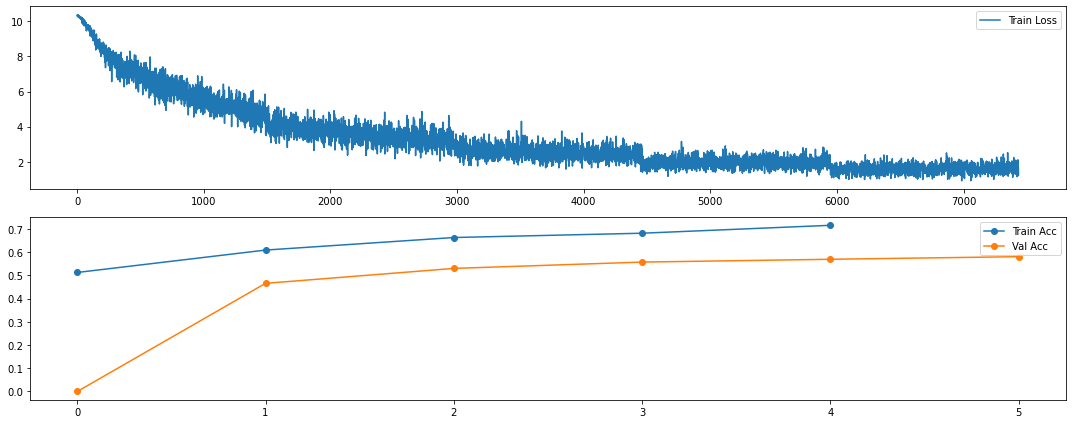




pos_is_causal: False  | pos_normalize_magnitude: False  | pos_exponent: 1.5


val: 0.000; epoch [0] loss: 4.723:  98%|██████████████████████████████████████████▎| 1463/1487 [08:58<00:08,  2.75it/s]


A
 tensor([[7.2042e-01, 2.3779e-01, 3.7782e-02, 3.7811e-03, 2.2659e-04],
        [1.9711e-01, 5.6450e-01, 2.0369e-01, 3.1765e-02, 2.9369e-03],
        [3.2411e-02, 2.0260e-01, 5.2299e-01, 2.1011e-01, 3.1890e-02],
        [3.0717e-03, 3.1284e-02, 1.9404e-01, 5.6845e-01, 2.0316e-01],
        [2.3093e-04, 3.7070e-03, 3.7983e-02, 2.5348e-01, 7.0460e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -1.0000, -2.8284, -5.1962, -8.0000],
        [-1.0000, -0.0000, -1.0000, -2.8284, -5.1962],
        [-2.8284, -1.0000, -0.0000, -1.0000, -2.8284],
        [-5.1962, -2.8284, -1.0000, -0.0000, -1.0000],
        [-8.0000, -5.1962, -2.8284, -1.0000, -0.0000]], device='cuda:0')


val: 0.464; epoch [1] loss: 3.313:  85%|████████████████████████████████████▍      | 1261/1487 [07:46<01:22,  2.73it/s]


A
 tensor([[6.9776e-01, 2.5738e-01, 4.0883e-02, 3.7415e-03, 2.2688e-04],
        [1.8699e-01, 5.8592e-01, 1.9398e-01, 3.0054e-02, 2.8633e-03],
        [3.1663e-02, 2.0386e-01, 5.3289e-01, 1.9633e-01, 3.2113e-02],
        [3.0350e-03, 3.2362e-02, 1.9822e-01, 5.2412e-01, 2.0490e-01],
        [1.7545e-04, 2.8601e-03, 3.0275e-02, 1.9910e-01, 5.4325e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -1.0000, -2.8284, -5.1962, -8.0000],
        [-1.0000, -0.0000, -1.0000, -2.8284, -5.1962],
        [-2.8284, -1.0000, -0.0000, -1.0000, -2.8284],
        [-5.1962, -2.8284, -1.0000, -0.0000, -1.0000],
        [-8.0000, -5.1962, -2.8284, -1.0000, -0.0000]], device='cuda:0')


val: 0.531; epoch [2] loss: 2.544:  44%|███████████████████▎                        | 652/1487 [04:01<05:29,  2.53it/s]


A
 tensor([[6.9266e-01, 2.6129e-01, 4.1984e-02, 3.8088e-03, 2.4512e-04],
        [2.0879e-01, 5.4225e-01, 2.1187e-01, 3.3769e-02, 3.1354e-03],
        [3.1185e-02, 1.9263e-01, 5.4336e-01, 1.9830e-01, 3.1606e-02],
        [2.9428e-03, 3.2744e-02, 2.0324e-01, 5.3352e-01, 1.9481e-01],
        [1.9618e-04, 3.0313e-03, 3.4243e-02, 2.0950e-01, 5.4621e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -1.0000, -2.8284, -5.1962, -8.0000],
        [-1.0000, -0.0000, -1.0000, -2.8284, -5.1962],
        [-2.8284, -1.0000, -0.0000, -1.0000, -2.8284],
        [-5.1962, -2.8284, -1.0000, -0.0000, -1.0000],
        [-8.0000, -5.1962, -2.8284, -1.0000, -0.0000]], device='cuda:0')


evaluate:   2%|█▋                                                                    | 35/1487 [00:01<01:22, 17.70it/s]


A
 tensor([[6.8890e-01, 2.6313e-01, 4.3346e-02, 4.3716e-03, 2.3928e-04],
        [2.3019e-01, 5.1554e-01, 2.1571e-01, 3.5192e-02, 3.1468e-03],
        [3.3029e-02, 2.0767e-01, 5.2872e-01, 1.9533e-01, 3.1752e-02],
        [5.2788e-03, 4.7949e-02, 2.7368e-01, 3.3460e-01, 2.8192e-01],
        [2.4375e-04, 3.6238e-03, 3.9671e-02, 2.4465e-01, 3.9451e-01]],
       device='cuda:0')

pos_rep
 tensor([[-0.0000, -1.0000, -2.8284, -5.1962, -8.0000],
        [-1.0000, -0.0000, -1.0000, -2.8284, -5.1962],
        [-2.8284, -1.0000, -0.0000, -1.0000, -2.8284],
        [-5.1962, -2.8284, -1.0000, -0.0000, -1.0000],
        [-8.0000, -5.1962, -2.8284, -1.0000, -0.0000]], device='cuda:0')


val: 0.559; epoch [3] loss: 1.928:  43%|██████████████████▊                         | 637/1487 [03:54<05:16,  2.68it/s]


A
 tensor([[6.7710e-01, 2.7437e-01, 4.3945e-02, 4.3215e-03, 2.4878e-04],
        [2.2323e-01, 5.3118e-01, 2.0698e-01, 3.5152e-02, 3.2419e-03],
        [4.0448e-02, 2.1468e-01, 4.5699e-01, 2.4385e-01, 4.0355e-02],
        [3.0991e-03, 3.3304e-02, 2.0603e-01, 5.1025e-01, 2.1026e-01],
        [2.3475e-04, 3.7651e-03, 4.2310e-02, 2.6334e-01, 4.1689e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -1.0000, -2.8284, -5.1962, -8.0000],
        [-1.0000, -0.0000, -1.0000, -2.8284, -5.1962],
        [-2.8284, -1.0000, -0.0000, -1.0000, -2.8284],
        [-5.1962, -2.8284, -1.0000, -0.0000, -1.0000],
        [-8.0000, -5.1962, -2.8284, -1.0000, -0.0000]], device='cuda:0')


val: 0.574; epoch [4] loss: 1.559:  57%|████████████████████████▉                   | 841/1487 [05:10<03:59,  2.70it/s]


A
 tensor([[5.5840e-01, 3.6977e-01, 6.6058e-02, 5.4333e-03, 3.2452e-04],
        [2.2715e-01, 4.7358e-01, 2.5803e-01, 3.7607e-02, 3.3974e-03],
        [3.5564e-02, 2.4783e-01, 4.5143e-01, 2.2793e-01, 3.3848e-02],
        [3.2487e-03, 3.5131e-02, 2.1705e-01, 4.9160e-01, 2.1391e-01],
        [1.9007e-04, 3.4827e-03, 3.8909e-02, 2.5776e-01, 4.2572e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -1.0000, -2.8284, -5.1962, -8.0000],
        [-1.0000, -0.0000, -1.0000, -2.8284, -5.1962],
        [-2.8284, -1.0000, -0.0000, -1.0000, -2.8284],
        [-5.1962, -2.8284, -1.0000, -0.0000, -1.0000],
        [-8.0000, -5.1962, -2.8284, -1.0000, -0.0000]], device='cuda:0')


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 30.83it/s]


Validation accuracy: 0.584, Training accuracy:0.718


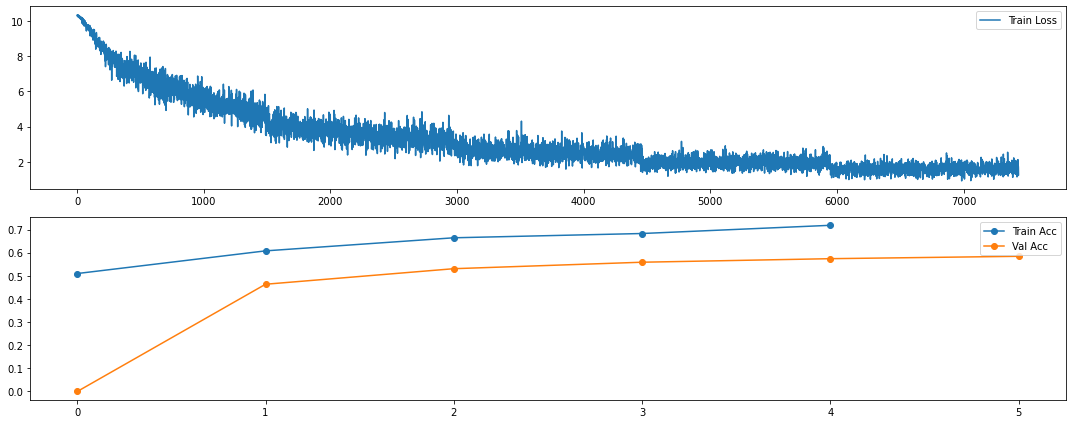




pos_is_causal: False  | pos_normalize_magnitude: False  | pos_exponent: 2


val: 0.000; epoch [0] loss: 4.725:  98%|██████████████████████████████████████████▎| 1463/1487 [08:59<00:08,  2.67it/s]


A
 tensor([[7.4274e-01, 2.4507e-01, 1.2105e-02, 8.6973e-05, 7.8556e-08],
        [2.0208e-01, 5.7900e-01, 2.0875e-01, 1.0094e-02, 6.7203e-05],
        [1.0520e-02, 2.1213e-01, 5.4661e-01, 2.2035e-01, 1.0387e-02],
        [7.0072e-05, 9.9382e-03, 1.9917e-01, 5.8281e-01, 2.0800e-01],
        [7.9857e-08, 8.5068e-05, 1.2163e-02, 2.6094e-01, 7.2681e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[ -0.,  -1.,  -4.,  -9., -16.],
        [ -1.,  -0.,  -1.,  -4.,  -9.],
        [ -4.,  -1.,  -0.,  -1.,  -4.],
        [ -9.,  -4.,  -1.,  -0.,  -1.],
        [-16.,  -9.,  -4.,  -1.,  -0.]], device='cuda:0')


val: 0.463; epoch [1] loss: 3.316:  85%|████████████████████████████████████▍      | 1261/1487 [07:45<01:27,  2.58it/s]


A
 tensor([[7.2063e-01, 2.6617e-01, 1.3109e-02, 8.6375e-05, 7.8569e-08],
        [1.9006e-01, 6.0288e-01, 1.9757e-01, 9.4273e-03, 6.4687e-05],
        [1.0299e-02, 2.1409e-01, 5.5868e-01, 2.0641e-01, 1.0449e-02],
        [7.1336e-05, 1.0588e-02, 2.0920e-01, 5.5339e-01, 2.1551e-01],
        [6.2134e-08, 6.7260e-05, 9.9181e-03, 2.0949e-01, 5.6849e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[ -0.,  -1.,  -4.,  -9., -16.],
        [ -1.,  -0.,  -1.,  -4.,  -9.],
        [ -4.,  -1.,  -0.,  -1.,  -4.],
        [ -9.,  -4.,  -1.,  -0.,  -1.],
        [-16.,  -9.,  -4.,  -1.,  -0.]], device='cuda:0')


val: 0.531; epoch [2] loss: 2.546:  44%|███████████████████▎                        | 652/1487 [04:01<05:01,  2.77it/s]


A
 tensor([[7.1672e-01, 2.6974e-01, 1.3453e-02, 8.7638e-05, 8.4721e-08],
        [2.1428e-01, 5.5719e-01, 2.1772e-01, 1.0734e-02, 7.1693e-05],
        [1.0129e-02, 2.0133e-01, 5.7042e-01, 2.0781e-01, 1.0244e-02],
        [6.8624e-05, 1.0634e-02, 2.1359e-01, 5.6010e-01, 2.0496e-01],
        [6.7502e-08, 6.9561e-05, 1.0935e-02, 2.1543e-01, 5.6144e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[ -0.,  -1.,  -4.,  -9., -16.],
        [ -1.,  -0.,  -1.,  -4.,  -9.],
        [ -4.,  -1.,  -0.,  -1.,  -4.],
        [ -9.,  -4.,  -1.,  -0.,  -1.],
        [-16.,  -9.,  -4.,  -1.,  -0.]], device='cuda:0')


evaluate:   2%|█▋                                                                    | 35/1487 [00:01<01:26, 16.75it/s]


A
 tensor([[7.1333e-01, 2.7262e-01, 1.3954e-02, 1.0181e-04, 8.3554e-08],
        [2.3801e-01, 5.2940e-01, 2.2128e-01, 1.1231e-02, 7.1375e-05],
        [1.0831e-02, 2.1837e-01, 5.5490e-01, 2.0552e-01, 1.0306e-02],
        [1.3049e-04, 1.6491e-02, 3.0194e-01, 3.5030e-01, 3.1350e-01],
        [8.6399e-08, 8.4994e-05, 1.2967e-02, 2.5967e-01, 4.2484e-01]],
       device='cuda:0')

pos_rep
 tensor([[ -0.,  -1.,  -4.,  -9., -16.],
        [ -1.,  -0.,  -1.,  -4.,  -9.],
        [ -4.,  -1.,  -0.,  -1.,  -4.],
        [ -9.,  -4.,  -1.,  -0.,  -1.],
        [-16.,  -9.,  -4.,  -1.,  -0.]], device='cuda:0')


val: 0.560; epoch [3] loss: 1.928:  43%|██████████████████▊                         | 637/1487 [03:55<05:11,  2.73it/s]


A
 tensor([[6.9891e-01, 2.8682e-01, 1.4171e-02, 1.0124e-04, 8.7337e-08],
        [2.2973e-01, 5.4623e-01, 2.1269e-01, 1.1273e-02, 7.4864e-05],
        [1.3234e-02, 2.2931e-01, 4.7989e-01, 2.6394e-01, 1.3542e-02],
        [7.3553e-05, 1.0945e-02, 2.1905e-01, 5.3500e-01, 2.2376e-01],
        [8.5355e-08, 9.1243e-05, 1.4298e-02, 2.8738e-01, 4.3507e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[ -0.,  -1.,  -4.,  -9., -16.],
        [ -1.,  -0.,  -1.,  -4.,  -9.],
        [ -4.,  -1.,  -0.,  -1.,  -4.],
        [ -9.,  -4.,  -1.,  -0.,  -1.],
        [-16.,  -9.,  -4.,  -1.,  -0.]], device='cuda:0')


val: 0.574; epoch [4] loss: 1.559:  57%|████████████████████████▉                   | 841/1487 [05:09<03:56,  2.74it/s]


A
 tensor([[5.8488e-01, 3.9369e-01, 2.1298e-02, 1.2980e-04, 1.1318e-07],
        [2.3519e-01, 4.9157e-01, 2.6124e-01, 1.1916e-02, 7.8049e-05],
        [1.1577e-02, 2.6030e-01, 4.7563e-01, 2.4145e-01, 1.0977e-02],
        [7.9267e-05, 1.1683e-02, 2.3181e-01, 5.1818e-01, 2.2637e-01],
        [6.7131e-08, 8.3644e-05, 1.2744e-02, 2.7735e-01, 4.4580e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[ -0.,  -1.,  -4.,  -9., -16.],
        [ -1.,  -0.,  -1.,  -4.,  -9.],
        [ -4.,  -1.,  -0.,  -1.,  -4.],
        [ -9.,  -4.,  -1.,  -0.,  -1.],
        [-16.,  -9.,  -4.,  -1.,  -0.]], device='cuda:0')


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:05<00:00, 37.05it/s]


Validation accuracy: 0.585, Training accuracy:0.717


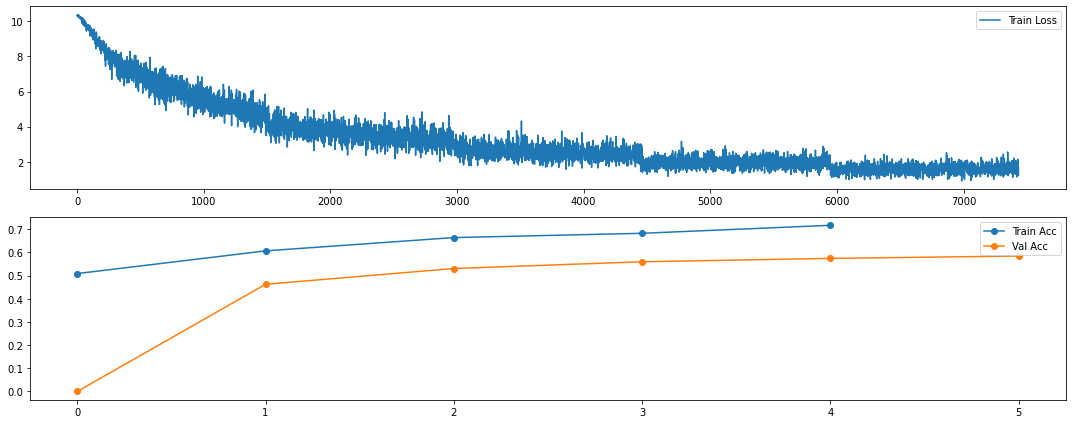




pos_is_causal: False  | pos_normalize_magnitude: True  | pos_exponent: 1


val: 0.000; epoch [0] loss: 4.745:  98%|██████████████████████████████████████████▎| 1463/1487 [09:03<00:09,  2.64it/s]


A
 tensor([[0.3081, 0.2356, 0.1868, 0.1497, 0.1198],
        [0.2148, 0.2765, 0.2176, 0.1699, 0.1212],
        [0.1534, 0.1890, 0.2632, 0.2033, 0.1911],
        [0.1324, 0.1630, 0.2138, 0.2730, 0.2178],
        [0.1056, 0.1327, 0.1627, 0.2200, 0.3791]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.2408, -0.4815, -0.7223, -0.9630],
        [-0.2408, -0.0000, -0.2408, -0.4815, -0.7223],
        [-0.4815, -0.2408, -0.0000, -0.2408, -0.4815],
        [-0.7223, -0.4815, -0.2408, -0.0000, -0.2408],
        [-0.9630, -0.7223, -0.4815, -0.2408, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.463; epoch [1] loss: 3.312:  85%|████████████████████████████████████▍      | 1261/1487 [07:48<01:23,  2.71it/s]


A
 tensor([[0.1406, 0.1154, 0.0976, 0.0745, 0.0633],
        [0.1021, 0.1173, 0.1071, 0.0892, 0.0698],
        [0.0802, 0.0979, 0.1207, 0.0959, 0.0822],
        [0.0620, 0.0782, 0.0940, 0.1118, 0.0963],
        [0.0485, 0.0570, 0.0733, 0.0919, 0.1104]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.1995, -0.3990, -0.5986, -0.7981],
        [-0.1995, -0.0000, -0.1995, -0.3990, -0.5986],
        [-0.3990, -0.1995, -0.0000, -0.1995, -0.3990],
        [-0.5986, -0.3990, -0.1995, -0.0000, -0.1995],
        [-0.7981, -0.5986, -0.3990, -0.1995, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.523; epoch [2] loss: 2.548:  44%|███████████████████▎                        | 652/1487 [04:01<05:09,  2.70it/s]


A
 tensor([[0.3365, 0.2407, 0.1684, 0.1131, 0.0824],
        [0.2064, 0.2859, 0.2070, 0.1399, 0.0971],
        [0.1298, 0.1917, 0.2601, 0.1917, 0.1318],
        [0.0910, 0.1357, 0.1919, 0.2655, 0.1864],
        [0.0698, 0.0985, 0.1459, 0.2064, 0.2846]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.3670, -0.7340, -1.1010, -1.4680],
        [-0.3670, -0.0000, -0.3670, -0.7340, -1.1010],
        [-0.7340, -0.3670, -0.0000, -0.3670, -0.7340],
        [-1.1010, -0.7340, -0.3670, -0.0000, -0.3670],
        [-1.4680, -1.1010, -0.7340, -0.3670, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


evaluate:   2%|█▋                                                                    | 35/1487 [00:02<01:30, 16.11it/s]


A
 tensor([[0.3129, 0.2103, 0.1460, 0.0960, 0.0603],
        [0.1795, 0.2509, 0.1765, 0.1177, 0.0790],
        [0.1036, 0.1601, 0.2275, 0.1579, 0.1081],
        [0.0708, 0.0990, 0.1490, 0.1922, 0.1540],
        [0.0447, 0.0635, 0.0971, 0.1442, 0.1875]], device='cuda:0')

pos_rep
 tensor([[-0.0000, -0.4081, -0.8163, -1.2244, -1.6325],
        [-0.4081, -0.0000, -0.4081, -0.8163, -1.2244],
        [-0.8163, -0.4081, -0.0000, -0.4081, -0.8163],
        [-1.2244, -0.8163, -0.4081, -0.0000, -0.4081],
        [-1.6325, -1.2244, -0.8163, -0.4081, -0.0000]], device='cuda:0')


val: 0.551; epoch [3] loss: 1.949:  43%|██████████████████▊                         | 637/1487 [03:56<05:12,  2.72it/s]


A
 tensor([[0.3619, 0.2462, 0.1503, 0.0972, 0.0643],
        [0.2017, 0.2940, 0.1914, 0.1259, 0.0826],
        [0.0666, 0.0867, 0.0804, 0.1102, 0.1129],
        [0.0676, 0.1104, 0.1840, 0.2555, 0.1693],
        [0.0441, 0.0674, 0.1051, 0.1782, 0.2564]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.4677, -0.9355, -1.4032, -1.8710],
        [-0.4677, -0.0000, -0.4677, -0.9355, -1.4032],
        [-0.9355, -0.4677, -0.0000, -0.4677, -0.9355],
        [-1.4032, -0.9355, -0.4677, -0.0000, -0.4677],
        [-1.8710, -1.4032, -0.9355, -0.4677, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.561; epoch [4] loss: 1.583:  57%|████████████████████████▉                   | 841/1487 [05:12<04:03,  2.66it/s]


A
 tensor([[0.3407, 0.2505, 0.1543, 0.0848, 0.0527],
        [0.1911, 0.2577, 0.2211, 0.1226, 0.0680],
        [0.1063, 0.1866, 0.2393, 0.1840, 0.1039],
        [0.0580, 0.0947, 0.1676, 0.2394, 0.1742],
        [0.0338, 0.0555, 0.1040, 0.1764, 0.1889]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.5258, -1.0515, -1.5773, -2.1031],
        [-0.5258, -0.0000, -0.5258, -1.0515, -1.5773],
        [-1.0515, -0.5258, -0.0000, -0.5258, -1.0515],
        [-1.5773, -1.0515, -0.5258, -0.0000, -0.5258],
        [-2.1031, -1.5773, -1.0515, -0.5258, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:05<00:00, 36.10it/s]


Validation accuracy: 0.573, Training accuracy:0.711


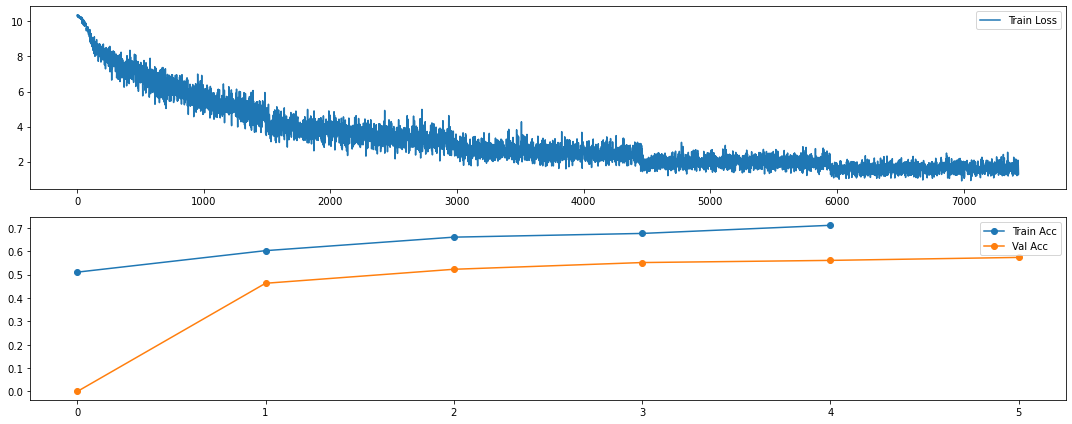




pos_is_causal: False  | pos_normalize_magnitude: True  | pos_exponent: 1.5


val: 0.000; epoch [0] loss: 4.749:  98%|██████████████████████████████████████████▎| 1463/1487 [05:17<00:05,  4.53it/s]


A
 tensor([[0.2458, 0.2246, 0.2021, 0.1780, 0.1496],
        [0.2125, 0.2288, 0.2149, 0.1912, 0.1527],
        [0.1748, 0.1898, 0.2204, 0.2035, 0.2116],
        [0.1640, 0.1837, 0.2118, 0.2265, 0.2140],
        [0.1392, 0.1638, 0.1826, 0.2163, 0.2980]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.0617, -0.1745, -0.3206, -0.4936],
        [-0.0617, -0.0000, -0.0617, -0.1745, -0.3206],
        [-0.1745, -0.0617, -0.0000, -0.0617, -0.1745],
        [-0.3206, -0.1745, -0.0617, -0.0000, -0.0617],
        [-0.4936, -0.3206, -0.1745, -0.0617, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.462; epoch [1] loss: 3.315:  85%|████████████████████████████████████▍      | 1261/1487 [04:38<00:50,  4.52it/s]


A
 tensor([[0.1209, 0.1131, 0.1047, 0.0841, 0.0738],
        [0.0999, 0.1014, 0.1049, 0.0953, 0.0790],
        [0.0851, 0.0954, 0.1031, 0.0932, 0.0877],
        [0.0689, 0.0821, 0.0905, 0.0949, 0.0928],
        [0.0552, 0.0630, 0.0766, 0.0876, 0.0931]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.0607, -0.1716, -0.3153, -0.4855],
        [-0.0607, -0.0000, -0.0607, -0.1716, -0.3153],
        [-0.1716, -0.0607, -0.0000, -0.0607, -0.1716],
        [-0.3153, -0.1716, -0.0607, -0.0000, -0.0607],
        [-0.4855, -0.3153, -0.1716, -0.0607, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.522; epoch [2] loss: 2.547:  44%|███████████████████▎                        | 652/1487 [02:23<03:06,  4.48it/s]


A
 tensor([[0.2778, 0.2433, 0.1899, 0.1324, 0.0930],
        [0.2097, 0.2362, 0.2099, 0.1586, 0.1133],
        [0.1450, 0.1923, 0.2123, 0.1929, 0.1470],
        [0.1043, 0.1496, 0.1898, 0.2162, 0.1850],
        [0.0790, 0.1149, 0.1648, 0.2095, 0.2355]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.1420, -0.4016, -0.7379, -1.1360],
        [-0.1420, -0.0000, -0.1420, -0.4016, -0.7379],
        [-0.4016, -0.1420, -0.0000, -0.1420, -0.4016],
        [-0.7379, -0.4016, -0.1420, -0.0000, -0.1420],
        [-1.1360, -0.7379, -0.4016, -0.1420, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:34, 15.30it/s]


A
 tensor([[0.2981, 0.2467, 0.1842, 0.1177, 0.0667],
        [0.2036, 0.2334, 0.2006, 0.1436, 0.0935],
        [0.1231, 0.1772, 0.2043, 0.1750, 0.1283],
        [0.0795, 0.1148, 0.1614, 0.1761, 0.1659],
        [0.0451, 0.0716, 0.1118, 0.1552, 0.1700]], device='cuda:0')

pos_rep
 tensor([[-0.0000, -0.1830, -0.5176, -0.9510, -1.4641],
        [-0.1830, -0.0000, -0.1830, -0.5176, -0.9510],
        [-0.5176, -0.1830, -0.0000, -0.1830, -0.5176],
        [-0.9510, -0.5176, -0.1830, -0.0000, -0.1830],
        [-1.4641, -0.9510, -0.5176, -0.1830, -0.0000]], device='cuda:0')


val: 0.552; epoch [3] loss: 1.941:  43%|██████████████████▊                         | 637/1487 [02:19<03:08,  4.51it/s]


A
 tensor([[0.3206, 0.2738, 0.1810, 0.1102, 0.0633],
        [0.2167, 0.2524, 0.2092, 0.1452, 0.0912],
        [0.0698, 0.0859, 0.0740, 0.1061, 0.1177],
        [0.0717, 0.1228, 0.1893, 0.2117, 0.1764],
        [0.0406, 0.0716, 0.1159, 0.1840, 0.2172]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.2175, -0.6152, -1.1301, -1.7399],
        [-0.2175, -0.0000, -0.2175, -0.6152, -1.1301],
        [-0.6152, -0.2175, -0.0000, -0.2175, -0.6152],
        [-1.1301, -0.6152, -0.2175, -0.0000, -0.2175],
        [-1.7399, -1.1301, -0.6152, -0.2175, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.562; epoch [4] loss: 1.569:  57%|████████████████████████▉                   | 841/1487 [03:04<02:22,  4.55it/s]


A
 tensor([[0.3260, 0.2949, 0.1897, 0.0986, 0.0513],
        [0.2135, 0.2342, 0.2497, 0.1517, 0.0777],
        [0.1260, 0.2067, 0.2091, 0.2043, 0.1231],
        [0.0637, 0.1132, 0.1847, 0.2097, 0.1912],
        [0.0308, 0.0619, 0.1202, 0.1921, 0.1700]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.2500, -0.7072, -1.2992, -2.0003],
        [-0.2500, -0.0000, -0.2500, -0.7072, -1.2992],
        [-0.7072, -0.2500, -0.0000, -0.2500, -0.7072],
        [-1.2992, -0.7072, -0.2500, -0.0000, -0.2500],
        [-2.0003, -1.2992, -0.7072, -0.2500, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 28.74it/s]


Validation accuracy: 0.575, Training accuracy:0.717


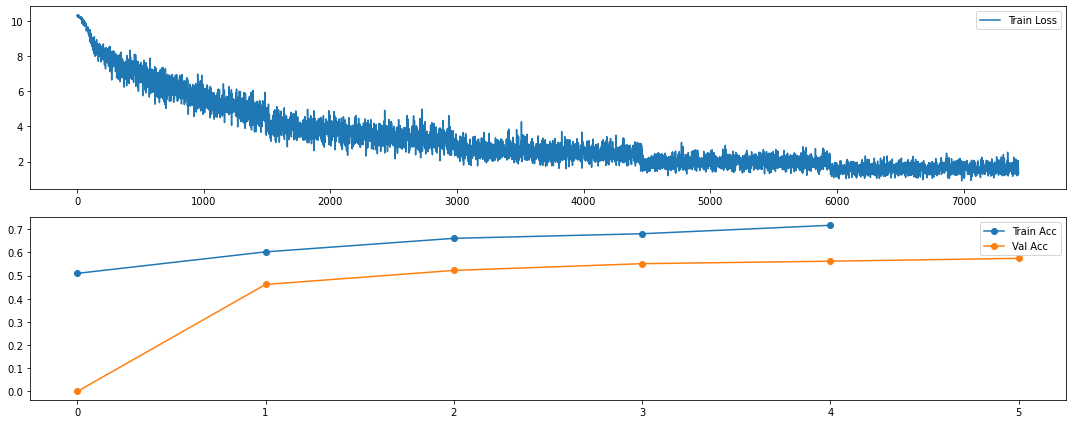




pos_is_causal: False  | pos_normalize_magnitude: True  | pos_exponent: 2


val: 0.000; epoch [0] loss: 4.753:  98%|██████████████████████████████████████████▎| 1463/1487 [05:22<00:05,  4.48it/s]


A
 tensor([[0.2219, 0.2123, 0.2033, 0.1922, 0.1703],
        [0.2069, 0.2128, 0.2095, 0.1989, 0.1718],
        [0.1850, 0.1881, 0.2078, 0.2015, 0.2176],
        [0.1824, 0.1908, 0.2060, 0.2107, 0.2101],
        [0.1632, 0.1801, 0.1880, 0.2078, 0.2609]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.0157, -0.0628, -0.1413, -0.2512],
        [-0.0157, -0.0000, -0.0157, -0.0628, -0.1413],
        [-0.0628, -0.0157, -0.0000, -0.0157, -0.0628],
        [-0.1413, -0.0628, -0.0157, -0.0000, -0.0157],
        [-0.2512, -0.1413, -0.0628, -0.0157, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.461; epoch [1] loss: 3.319:  85%|████████████████████████████████████▍      | 1261/1487 [04:35<00:50,  4.46it/s]


A
 tensor([[0.1151, 0.1118, 0.1089, 0.0914, 0.0828],
        [0.0989, 0.0970, 0.1036, 0.0990, 0.0862],
        [0.0880, 0.0941, 0.0977, 0.0913, 0.0909],
        [0.0739, 0.0840, 0.0881, 0.0893, 0.0904],
        [0.0608, 0.0672, 0.0781, 0.0846, 0.0870]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.0198, -0.0793, -0.1784, -0.3171],
        [-0.0198, -0.0000, -0.0198, -0.0793, -0.1784],
        [-0.0793, -0.0198, -0.0000, -0.0198, -0.0793],
        [-0.1784, -0.0793, -0.0198, -0.0000, -0.0198],
        [-0.3171, -0.1784, -0.0793, -0.0198, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.521; epoch [2] loss: 2.554:  44%|███████████████████▎                        | 652/1487 [02:19<03:03,  4.54it/s]


A
 tensor([[0.2305, 0.2198, 0.1951, 0.1527, 0.1164],
        [0.1980, 0.2042, 0.1973, 0.1700, 0.1351],
        [0.1561, 0.1829, 0.1853, 0.1835, 0.1584],
        [0.1253, 0.1595, 0.1786, 0.1881, 0.1743],
        [0.1031, 0.1373, 0.1758, 0.1969, 0.2040]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.0447, -0.1788, -0.4024, -0.7153],
        [-0.0447, -0.0000, -0.0447, -0.1788, -0.4024],
        [-0.1788, -0.0447, -0.0000, -0.0447, -0.1788],
        [-0.4024, -0.1788, -0.0447, -0.0000, -0.0447],
        [-0.7153, -0.4024, -0.1788, -0.0447, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:32, 15.67it/s]


A
 tensor([[0.2577, 0.2358, 0.2001, 0.1402, 0.0825],
        [0.1958, 0.2048, 0.1936, 0.1571, 0.1118],
        [0.1331, 0.1686, 0.1758, 0.1666, 0.1388],
        [0.0919, 0.1213, 0.1505, 0.1525, 0.1547],
        [0.0537, 0.0826, 0.1172, 0.1436, 0.1451]], device='cuda:0')

pos_rep
 tensor([[-0.0000, -0.0683, -0.2732, -0.6147, -1.0928],
        [-0.0683, -0.0000, -0.0683, -0.2732, -0.6147],
        [-0.2732, -0.0683, -0.0000, -0.0683, -0.2732],
        [-0.6147, -0.2732, -0.0683, -0.0000, -0.0683],
        [-1.0928, -0.6147, -0.2732, -0.0683, -0.0000]], device='cuda:0')


val: 0.550; epoch [3] loss: 1.949:  43%|██████████████████▊                         | 637/1487 [02:18<03:08,  4.50it/s]


A
 tensor([[0.2767, 0.2630, 0.2019, 0.1316, 0.0761],
        [0.2090, 0.2185, 0.2048, 0.1608, 0.1100],
        [0.0804, 0.0857, 0.0778, 0.1028, 0.1261],
        [0.0844, 0.1331, 0.1773, 0.1800, 0.1666],
        [0.0476, 0.0836, 0.1248, 0.1719, 0.1886]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.0867, -0.3467, -0.7801, -1.3868],
        [-0.0867, -0.0000, -0.0867, -0.3467, -0.7801],
        [-0.3467, -0.0867, -0.0000, -0.0867, -0.3467],
        [-0.7801, -0.3467, -0.0867, -0.0000, -0.0867],
        [-1.3868, -0.7801, -0.3467, -0.0867, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


val: 0.560; epoch [4] loss: 1.575:  57%|████████████████████████▉                   | 841/1487 [03:04<02:23,  4.51it/s]


A
 tensor([[0.2938, 0.2922, 0.2115, 0.1165, 0.0570],
        [0.2076, 0.2116, 0.2461, 0.1730, 0.0926],
        [0.1390, 0.2012, 0.1840, 0.1995, 0.1372],
        [0.0733, 0.1260, 0.1785, 0.1832, 0.1844],
        [0.0330, 0.0714, 0.1309, 0.1836, 0.1505]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000, -0.1085, -0.4341, -0.9767, -1.7363],
        [-0.1085, -0.0000, -0.1085, -0.4341, -0.9767],
        [-0.4341, -0.1085, -0.0000, -0.1085, -0.4341],
        [-0.9767, -0.4341, -0.1085, -0.0000, -0.1085],
        [-1.7363, -0.9767, -0.4341, -0.1085, -0.0000]], device='cuda:0',
       grad_fn=<SliceBackward>)


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 28.64it/s]


Validation accuracy: 0.573, Training accuracy:0.715


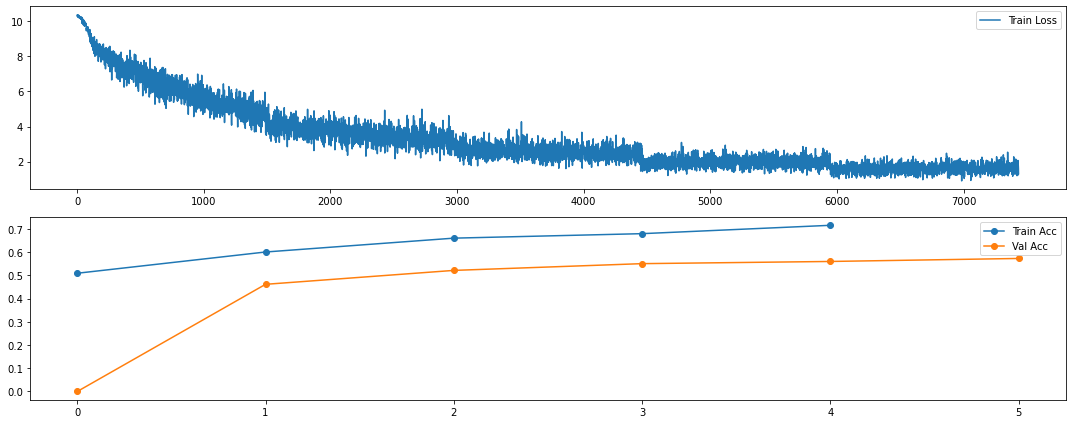




pos_is_causal: True  | pos_normalize_magnitude: False  | pos_exponent: 1


val: 0.000; epoch [0] loss: 4.721:  98%|██████████████████████████████████████████▎| 1463/1487 [05:24<00:05,  4.49it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2595, 0.7405, 0.0000, 0.0000, 0.0000],
        [0.0982, 0.2688, 0.6330, 0.0000, 0.0000],
        [0.0324, 0.0834, 0.2270, 0.6572, 0.0000],
        [0.0113, 0.0302, 0.0764, 0.2266, 0.6554]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-4.0000e+00, -3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.463; epoch [1] loss: 3.341:  85%|████████████████████████████████████▍      | 1261/1487 [04:39<00:50,  4.51it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2426, 0.7574, 0.0000, 0.0000, 0.0000],
        [0.0895, 0.2552, 0.6553, 0.0000, 0.0000],
        [0.0329, 0.0922, 0.2463, 0.6285, 0.0000],
        [0.0107, 0.0290, 0.0751, 0.2134, 0.6717]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-4.0000e+00, -3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.525; epoch [2] loss: 2.584:  44%|███████████████████▎                        | 652/1487 [02:20<03:02,  4.58it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2909, 0.7091, 0.0000, 0.0000, 0.0000],
        [0.0897, 0.2429, 0.6674, 0.0000, 0.0000],
        [0.0314, 0.0916, 0.2390, 0.6380, 0.0000],
        [0.0120, 0.0306, 0.0901, 0.2347, 0.6326]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-4.0000e+00, -3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:34, 15.38it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3098, 0.6902, 0.0000, 0.0000, 0.0000],
        [0.0921, 0.2523, 0.6556, 0.0000, 0.0000],
        [0.0870, 0.1749, 0.4429, 0.2952, 0.0000],
        [0.0218, 0.0510, 0.1482, 0.3195, 0.4595]], device='cuda:0')

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-4.0000e+00, -3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.550; epoch [3] loss: 1.995:  43%|██████████████████▊                         | 637/1487 [02:19<03:05,  4.58it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2896, 0.7104, 0.0000, 0.0000, 0.0000],
        [0.0975, 0.2278, 0.6747, 0.0000, 0.0000],
        [0.0334, 0.0913, 0.2456, 0.6296, 0.0000],
        [0.0156, 0.0413, 0.1186, 0.3246, 0.5000]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-4.0000e+00, -3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.559; epoch [4] loss: 1.660:  57%|████████████████████████▉                   | 841/1487 [03:04<02:21,  4.57it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3286, 0.6714, 0.0000, 0.0000, 0.0000],
        [0.0886, 0.2950, 0.6163, 0.0000, 0.0000],
        [0.0370, 0.0981, 0.2702, 0.5947, 0.0000],
        [0.0152, 0.0365, 0.0996, 0.2727, 0.5760]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-4.0000e+00, -3.0000e+00, -2.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 30.25it/s]


Validation accuracy: 0.565, Training accuracy:0.684


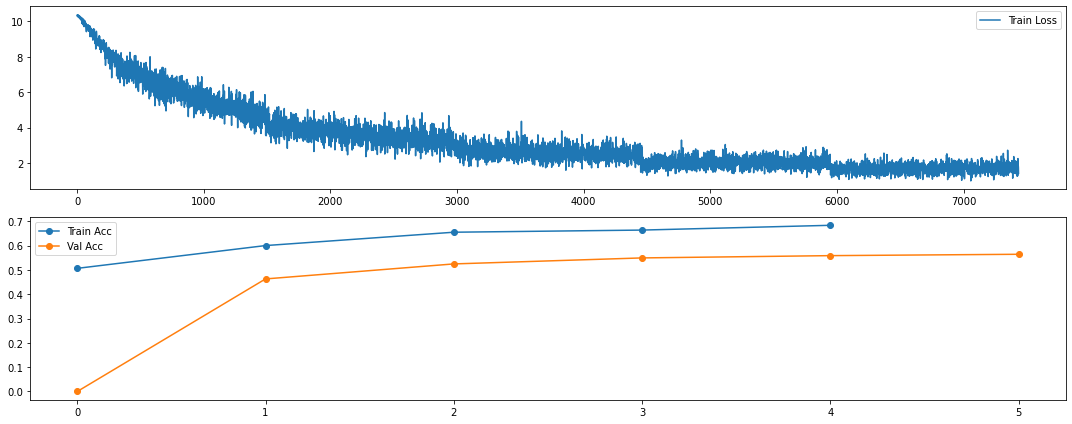




pos_is_causal: True  | pos_normalize_magnitude: False  | pos_exponent: 1.5


val: 0.000; epoch [0] loss: 4.724:  98%|██████████████████████████████████████████▎| 1463/1487 [05:13<00:05,  4.52it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.5985e-01, 7.4015e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.6054e-02, 2.8973e-01, 6.6422e-01, 0.0000e+00, 0.0000e+00],
        [3.8835e-03, 3.9474e-02, 2.4504e-01, 7.1160e-01, 0.0000e+00],
        [2.2529e-04, 3.6677e-03, 3.6608e-02, 2.4680e-01, 7.1270e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-8.0000e+00, -5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.463; epoch [1] loss: 3.346:  85%|████████████████████████████████████▍      | 1261/1487 [04:37<00:49,  4.54it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4119e-01, 7.5881e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1063e-02, 2.6898e-01, 6.8996e-01, 0.0000e+00, 0.0000e+00],
        [3.9933e-03, 4.4205e-02, 2.7135e-01, 6.8045e-01, 0.0000e+00],
        [2.1522e-04, 3.5508e-03, 3.6331e-02, 2.3447e-01, 7.2544e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-8.0000e+00, -5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.525; epoch [2] loss: 2.588:  44%|███████████████████▎                        | 652/1487 [02:21<03:05,  4.51it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9186e-01, 7.0814e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1475e-02, 2.5651e-01, 7.0201e-01, 0.0000e+00, 0.0000e+00],
        [3.7971e-03, 4.3282e-02, 2.6058e-01, 6.9234e-01, 0.0000e+00],
        [2.4207e-04, 3.7373e-03, 4.3717e-02, 2.5937e-01, 6.9294e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-8.0000e+00, -5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:33, 15.55it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1379e-01, 6.8621e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.3383e-02, 2.6905e-01, 6.8757e-01, 0.0000e+00, 0.0000e+00],
        [1.3538e-02, 1.0557e-01, 5.8813e-01, 2.9277e-01, 0.0000e+00],
        [4.4026e-04, 6.4209e-03, 7.1550e-02, 3.5131e-01, 5.7028e-01]],
       device='cuda:0')

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-8.0000e+00, -5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.550; epoch [3] loss: 1.997:  43%|██████████████████▊                         | 637/1487 [02:18<03:05,  4.59it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9190e-01, 7.0810e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.7147e-02, 2.5260e-01, 7.0025e-01, 0.0000e+00, 0.0000e+00],
        [4.1142e-03, 4.3518e-02, 2.7116e-01, 6.8121e-01, 0.0000e+00],
        [3.4366e-04, 5.5689e-03, 6.2968e-02, 3.9795e-01, 5.3316e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-8.0000e+00, -5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.559; epoch [4] loss: 1.662:  57%|████████████████████████▉                   | 841/1487 [03:02<02:20,  4.61it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.2203e-01, 6.7797e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1467e-02, 3.1087e-01, 6.4766e-01, 0.0000e+00, 0.0000e+00],
        [4.7341e-03, 4.8197e-02, 2.9580e-01, 6.5127e-01, 0.0000e+00],
        [3.1347e-04, 4.5096e-03, 4.8058e-02, 3.0269e-01, 6.4443e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-8.0000e+00, -5.1962e+00, -2.8284e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 30.47it/s]


Validation accuracy: 0.567, Training accuracy:0.684


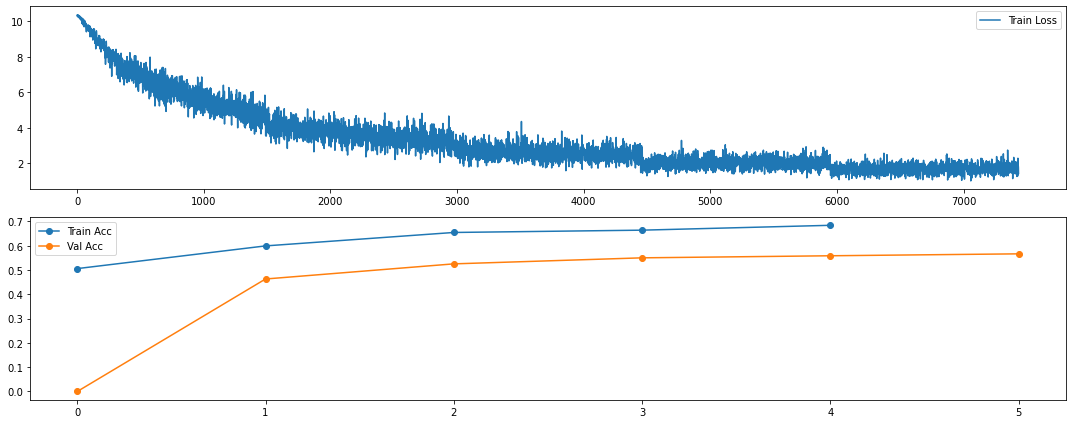




pos_is_causal: True  | pos_normalize_magnitude: False  | pos_exponent: 2


val: 0.000; epoch [0] loss: 4.726:  98%|██████████████████████████████████████████▎| 1463/1487 [05:15<00:05,  4.47it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.5950e-01, 7.4050e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4763e-02, 2.9968e-01, 6.8556e-01, 0.0000e+00, 0.0000e+00],
        [8.9075e-05, 1.2620e-02, 2.5225e-01, 7.3505e-01, 0.0000e+00],
        [7.7812e-08, 8.4132e-05, 1.1714e-02, 2.5384e-01, 7.3436e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-1.6000e+01, -9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.462; epoch [1] loss: 3.349:  85%|████████████████████████████████████▍      | 1261/1487 [04:34<00:49,  4.60it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.3999e-01, 7.6001e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3061e-02, 2.7581e-01, 7.1113e-01, 0.0000e+00, 0.0000e+00],
        [9.1603e-05, 1.4119e-02, 2.8002e-01, 7.0576e-01, 0.0000e+00],
        [7.4529e-08, 8.1639e-05, 1.1636e-02, 2.4222e-01, 7.4606e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-1.6000e+01, -9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.525; epoch [2] loss: 2.592:  44%|███████████████████▎                        | 652/1487 [02:18<02:59,  4.65it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9079e-01, 7.0921e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3224e-02, 2.6321e-01, 7.2357e-01, 0.0000e+00, 0.0000e+00],
        [8.6942e-05, 1.3803e-02, 2.6846e-01, 7.1765e-01, 0.0000e+00],
        [8.3582e-08, 8.6015e-05, 1.3998e-02, 2.6834e-01, 7.1758e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-1.6000e+01, -9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:33, 15.49it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1233e-01, 6.8767e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3902e-02, 2.7832e-01, 7.0778e-01, 0.0000e+00, 0.0000e+00],
        [3.3885e-04, 3.7293e-02, 6.5432e-01, 3.0805e-01, 0.0000e+00],
        [1.4699e-07, 1.4476e-04, 2.2104e-02, 3.5846e-01, 6.1929e-01]],
       device='cuda:0')

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-1.6000e+01, -9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.550; epoch [3] loss: 2.001:  43%|██████████████████▊                         | 637/1487 [02:17<03:03,  4.63it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9011e-01, 7.0989e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.5447e-02, 2.7190e-01, 7.1266e-01, 0.0000e+00, 0.0000e+00],
        [9.5338e-05, 1.3914e-02, 2.8143e-01, 7.0456e-01, 0.0000e+00],
        [1.2317e-07, 1.3365e-04, 2.0954e-02, 4.2922e-01, 5.4970e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-1.6000e+01, -9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


val: 0.558; epoch [4] loss: 1.665:  57%|████████████████████████▉                   | 841/1487 [03:01<02:18,  4.67it/s]


A
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1846e-01, 6.8154e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3352e-02, 3.1982e-01, 6.6683e-01, 0.0000e+00, 0.0000e+00],
        [1.1183e-04, 1.5690e-02, 3.0605e-01, 6.7815e-01, 0.0000e+00],
        [1.0803e-07, 1.0375e-04, 1.5260e-02, 3.1310e-01, 6.7154e-01]],
       device='cuda:0', grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00, -1.0000e+12],
        [-1.6000e+01, -9.0000e+00, -4.0000e+00, -1.0000e+00, -0.0000e+00]],
       device='cuda:0')


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 30.52it/s]


Validation accuracy: 0.566, Training accuracy:0.683


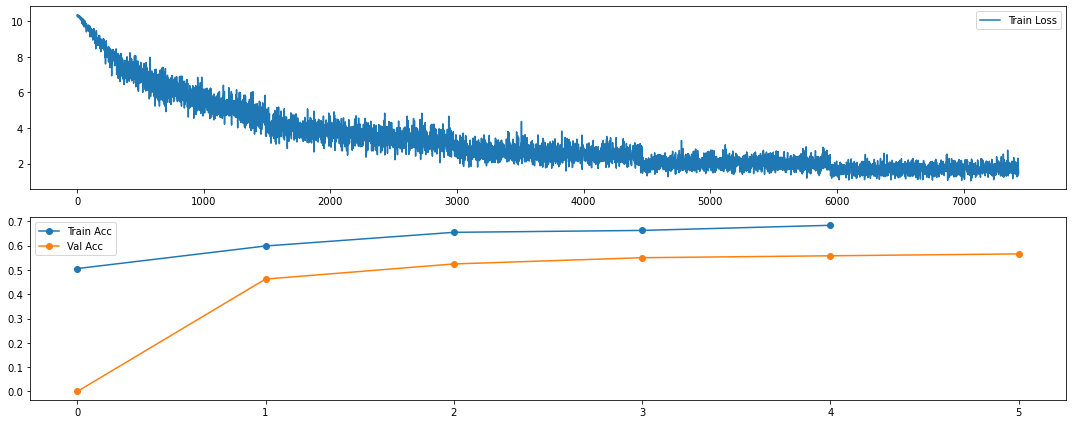




pos_is_causal: True  | pos_normalize_magnitude: True  | pos_exponent: 1


val: 0.000; epoch [0] loss: 4.743:  98%|██████████████████████████████████████████▎| 1463/1487 [05:16<00:05,  4.65it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3432, 0.6568, 0.0000, 0.0000, 0.0000],
        [0.1776, 0.3058, 0.5166, 0.0000, 0.0000],
        [0.0967, 0.1477, 0.2631, 0.4925, 0.0000],
        [0.0525, 0.0805, 0.1410, 0.2542, 0.4718]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.4047e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0809e+00, -5.4047e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.6214e+00, -1.0809e+00, -5.4047e-01, -0.0000e+00, -1.0000e+12],
        [-2.1619e+00, -1.6214e+00, -1.0809e+00, -5.4047e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.464; epoch [1] loss: 3.329:  85%|████████████████████████████████████▍      | 1261/1487 [04:33<00:50,  4.45it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3699, 0.6301, 0.0000, 0.0000, 0.0000],
        [0.1818, 0.3081, 0.5101, 0.0000, 0.0000],
        [0.0978, 0.1649, 0.2804, 0.4569, 0.0000],
        [0.0534, 0.0876, 0.1424, 0.2466, 0.4700]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.0863e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.0173e+00, -5.0863e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.5259e+00, -1.0173e+00, -5.0863e-01, -0.0000e+00, -1.0000e+12],
        [-2.0345e+00, -1.5259e+00, -1.0173e+00, -5.0863e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.525; epoch [2] loss: 2.571:  44%|███████████████████▎                        | 652/1487 [02:23<03:07,  4.45it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3919, 0.6081, 0.0000, 0.0000, 0.0000],
        [0.1884, 0.3043, 0.5073, 0.0000, 0.0000],
        [0.1044, 0.1741, 0.2722, 0.4493, 0.0000],
        [0.0613, 0.0967, 0.1625, 0.2570, 0.4224]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.8125e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-9.6249e-01, -4.8125e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.4437e+00, -9.6249e-01, -4.8125e-01, -0.0000e+00, -1.0000e+12],
        [-1.9250e+00, -1.4437e+00, -9.6249e-01, -4.8125e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:33, 15.55it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4188, 0.5812, 0.0000, 0.0000, 0.0000],
        [0.2005, 0.3104, 0.4891, 0.0000, 0.0000],
        [0.1471, 0.2013, 0.2985, 0.3531, 0.0000],
        [0.0895, 0.1222, 0.2020, 0.2875, 0.2988]], device='cuda:0')

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.2364e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-8.4729e-01, -4.2364e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.2709e+00, -8.4729e-01, -4.2364e-01, -0.0000e+00, -1.0000e+12],
        [-1.6946e+00, -1.2709e+00, -8.4729e-01, -4.2364e-01, -0.0000e+00]],
       device='cuda:0')


val: 0.550; epoch [3] loss: 1.977:  43%|██████████████████▊                         | 637/1487 [02:16<03:02,  4.66it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3942, 0.6058, 0.0000, 0.0000, 0.0000],
        [0.0081, 0.0087, 0.9832, 0.0000, 0.0000],
        [0.1190, 0.1915, 0.2349, 0.4546, 0.0000],
        [0.0778, 0.1126, 0.1925, 0.2688, 0.3483]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.3400e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-8.6801e-01, -4.3400e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.3020e+00, -8.6801e-01, -4.3400e-01, -0.0000e+00, -1.0000e+12],
        [-1.7360e+00, -1.3020e+00, -8.6801e-01, -4.3400e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.560; epoch [4] loss: 1.636:  57%|████████████████████████▉                   | 841/1487 [03:00<02:19,  4.63it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4369, 0.5631, 0.0000, 0.0000, 0.0000],
        [0.1989, 0.3465, 0.4546, 0.0000, 0.0000],
        [0.1190, 0.1827, 0.2921, 0.4062, 0.0000],
        [0.0760, 0.1128, 0.1794, 0.2734, 0.3585]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.3738e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-8.7476e-01, -4.3738e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.3121e+00, -8.7476e-01, -4.3738e-01, -0.0000e+00, -1.0000e+12],
        [-1.7495e+00, -1.3121e+00, -8.7476e-01, -4.3738e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 30.24it/s]


Validation accuracy: 0.564, Training accuracy:0.695


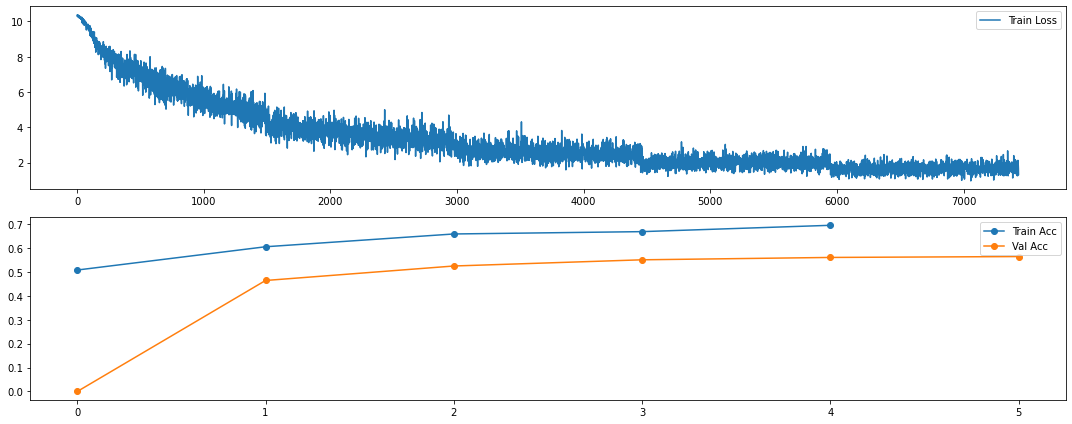




pos_is_causal: True  | pos_normalize_magnitude: True  | pos_exponent: 1.5


val: 0.000; epoch [0] loss: 4.760:  98%|██████████████████████████████████████████▎| 1463/1487 [05:14<00:05,  4.49it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4269, 0.5731, 0.0000, 0.0000, 0.0000],
        [0.2477, 0.3375, 0.4148, 0.0000, 0.0000],
        [0.1480, 0.1979, 0.2840, 0.3701, 0.0000],
        [0.0826, 0.1198, 0.1855, 0.2658, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.7230e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-4.8735e-01, -1.7230e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-8.9532e-01, -4.8735e-01, -1.7230e-01, -0.0000e+00, -1.0000e+12],
        [-1.3784e+00, -8.9532e-01, -4.8735e-01, -1.7230e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.463; epoch [1] loss: 3.332:  85%|████████████████████████████████████▍      | 1261/1487 [04:37<00:50,  4.50it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4407, 0.5593, 0.0000, 0.0000, 0.0000],
        [0.2395, 0.3405, 0.4200, 0.0000, 0.0000],
        [0.1330, 0.2086, 0.2973, 0.3612, 0.0000],
        [0.0709, 0.1175, 0.1786, 0.2607, 0.3724]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.8418e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.2093e-01, -1.8418e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.5701e-01, -5.2093e-01, -1.8418e-01, -0.0000e+00, -1.0000e+12],
        [-1.4734e+00, -9.5701e-01, -5.2093e-01, -1.8418e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.526; epoch [2] loss: 2.565:  44%|███████████████████▎                        | 652/1487 [02:18<03:02,  4.58it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4533, 0.5467, 0.0000, 0.0000, 0.0000],
        [0.2367, 0.3346, 0.4287, 0.0000, 0.0000],
        [0.1320, 0.2122, 0.2908, 0.3650, 0.0000],
        [0.0725, 0.1213, 0.1949, 0.2707, 0.3406]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.8972e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.3661e-01, -1.8972e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.8582e-01, -5.3661e-01, -1.8972e-01, -0.0000e+00, -1.0000e+12],
        [-1.5178e+00, -9.8582e-01, -5.3661e-01, -1.8972e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:35, 15.28it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4716, 0.5284, 0.0000, 0.0000, 0.0000],
        [0.2394, 0.3375, 0.4231, 0.0000, 0.0000],
        [0.1566, 0.2217, 0.3026, 0.3191, 0.0000],
        [0.0883, 0.1339, 0.2199, 0.2915, 0.2664]], device='cuda:0')

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.8144e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.1318e-01, -1.8144e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.4278e-01, -5.1318e-01, -1.8144e-01, -0.0000e+00, -1.0000e+12],
        [-1.4515e+00, -9.4278e-01, -5.1318e-01, -1.8144e-01, -0.0000e+00]],
       device='cuda:0')


val: 0.551; epoch [3] loss: 1.961:  43%|██████████████████▊                         | 637/1487 [02:19<03:05,  4.59it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4501, 0.5499, 0.0000, 0.0000, 0.0000],
        [0.0025, 0.0023, 0.9953, 0.0000, 0.0000],
        [0.1380, 0.2271, 0.2437, 0.3912, 0.0000],
        [0.0792, 0.1257, 0.2191, 0.2758, 0.3003]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.8922e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.3521e-01, -1.8922e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-9.8323e-01, -5.3521e-01, -1.8922e-01, -0.0000e+00, -1.0000e+12],
        [-1.5138e+00, -9.8323e-01, -5.3521e-01, -1.8922e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.560; epoch [4] loss: 1.611:  57%|████████████████████████▉                   | 841/1487 [03:03<02:24,  4.47it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4951, 0.5049, 0.0000, 0.0000, 0.0000],
        [0.2360, 0.3754, 0.3886, 0.0000, 0.0000],
        [0.1321, 0.2139, 0.3108, 0.3432, 0.0000],
        [0.0745, 0.1260, 0.2035, 0.2911, 0.3050]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.9812e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.6036e-01, -1.9812e-01, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-1.0294e+00, -5.6036e-01, -1.9812e-01, -0.0000e+00, -1.0000e+12],
        [-1.5849e+00, -1.0294e+00, -5.6036e-01, -1.9812e-01, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


evaluate: 100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 28.24it/s]


Validation accuracy: 0.566, Training accuracy:0.703


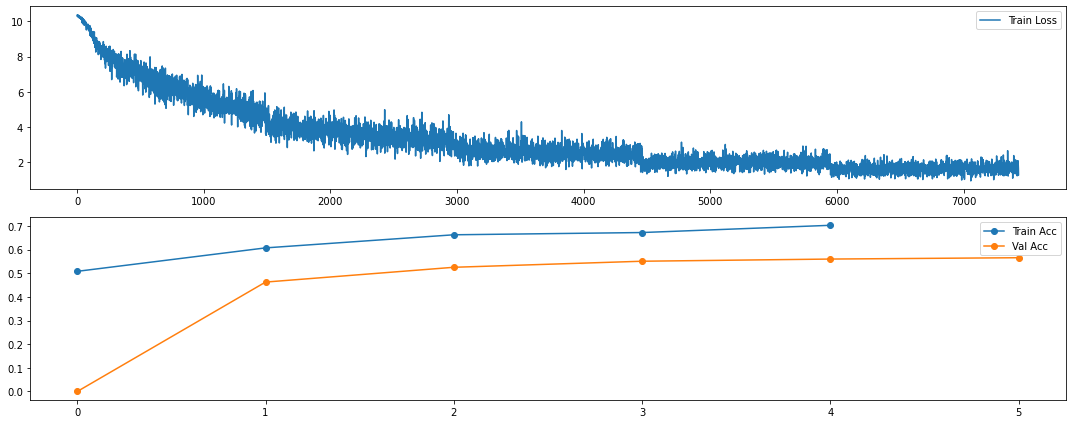




pos_is_causal: True  | pos_normalize_magnitude: True  | pos_exponent: 2


val: 0.000; epoch [0] loss: 4.771:  98%|██████████████████████████████████████████▎| 1463/1487 [05:13<00:05,  4.33it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4617, 0.5383, 0.0000, 0.0000, 0.0000],
        [0.2999, 0.3333, 0.3668, 0.0000, 0.0000],
        [0.2064, 0.2254, 0.2667, 0.3014, 0.0000],
        [0.1348, 0.1604, 0.2013, 0.2345, 0.2690]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-3.9232e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-1.5693e-01, -3.9232e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-3.5309e-01, -1.5693e-01, -3.9232e-02, -0.0000e+00, -1.0000e+12],
        [-6.2771e-01, -3.5309e-01, -1.5693e-01, -3.9232e-02, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.461; epoch [1] loss: 3.339:  85%|████████████████████████████████████▍      | 1261/1487 [04:30<00:50,  4.48it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4691, 0.5309, 0.0000, 0.0000, 0.0000],
        [0.2875, 0.3399, 0.3726, 0.0000, 0.0000],
        [0.1806, 0.2370, 0.2802, 0.3021, 0.0000],
        [0.1086, 0.1541, 0.1960, 0.2386, 0.3026]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-5.1230e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.0492e-01, -5.1230e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-4.6107e-01, -2.0492e-01, -5.1230e-02, -0.0000e+00, -1.0000e+12],
        [-8.1968e-01, -4.6107e-01, -2.0492e-01, -5.1230e-02, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


val: 0.523; epoch [2] loss: 2.570:  44%|███████████████████▎                        | 652/1487 [02:23<03:45,  3.70it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4788, 0.5212, 0.0000, 0.0000, 0.0000],
        [0.2803, 0.3359, 0.3838, 0.0000, 0.0000],
        [0.1731, 0.2393, 0.2787, 0.3089, 0.0000],
        [0.1026, 0.1547, 0.2118, 0.2505, 0.2804]], device='cuda:0',
       grad_fn=<SliceBackward>)

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-6.0290e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.4116e-01, -6.0290e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.4261e-01, -2.4116e-01, -6.0290e-02, -0.0000e+00, -1.0000e+12],
        [-9.6463e-01, -5.4261e-01, -2.4116e-01, -6.0290e-02, -0.0000e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


evaluate:   2%|█▌                                                                    | 34/1487 [00:02<01:43, 14.08it/s]


A
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4937, 0.5063, 0.0000, 0.0000, 0.0000],
        [0.2754, 0.3409, 0.3837, 0.0000, 0.0000],
        [0.1873, 0.2417, 0.2886, 0.2824, 0.0000],
        [0.1090, 0.1576, 0.2308, 0.2698, 0.2329]], device='cuda:0')

pos_rep
 tensor([[-0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-6.4551e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12, -1.0000e+12],
        [-2.5820e-01, -6.4551e-02, -0.0000e+00, -1.0000e+12, -1.0000e+12],
        [-5.8096e-01, -2.5820e-01, -6.4551e-02, -0.0000e+00, -1.0000e+12],
        [-1.0328e+00, -5.8096e-01, -2.5820e-01, -6.4551e-02, -0.0000e+00]],
       device='cuda:0')


evaluate:   4%|██▉                                                                   | 62/1487 [00:04<01:30, 15.76it/s]

In [ ]:
for pos_is_causal in [False, True]:
    for pos_normalize_magnitude in [False, True]:
        for pos_exponent in [1, 1.5, 2]:
            print("\n\n")
            print("==================================================================================")
            print("pos_is_causal:", pos_is_causal, " | pos_normalize_magnitude:", pos_normalize_magnitude,
                  " | pos_exponent:", pos_exponent)
            print("==================================================================================")
            train_eval_positional(num_epochs=5,
                                  pos_exponent=pos_exponent,
                                  pos_cutoff_position=10,
                                  pos_is_causal=pos_is_causal,
                                  pos_normalize_magnitude=pos_normalize_magnitude,
                                  DEBUG_dummy_train=False)